In [1]:
import argparse
from state import State
from data_loader import load_data
from agent import Agent
from attention import Attention
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from evaluate import computeF1, evaluate
import math

GAMMA = 0.5
WORD_EMB_DIM = 300
NODE_EMB_DIM = 16
H_DIM = 64
T = 3
NUM_EPOCH = 100
SOFT_REWARD_SCALE = 0.01
NUM_ROLL_OUT = 4

# load dataset
rel_embedding, kg, train, test = load_data("countries", WORD_EMB_DIM)

# projection from word embedding to node node embedding
word2node = nn.Linear(WORD_EMB_DIM, NODE_EMB_DIM, bias=False)

# mutihead self-attention
attention = Attention(2, NODE_EMB_DIM, H_DIM, math.sqrt(H_DIM))

# list contains all params that need to optimize
model_param_list = list(word2node.parameters()) + list(attention.parameters())

# init agent
state = State((train[0][1],train[0][2]), kg, WORD_EMB_DIM, word2node, attention, rel_embedding, T) # init here to calculate the input size
input_dim = state.get_input_size()
num_rel = len(kg.rel_vocab)
num_entity = len(kg.en_vocab)
agent = Agent(input_dim, 16, 0.1, 2, num_entity, num_rel, GAMMA, 0.0001, model_param_list)

# training loop
for epoch in range(NUM_EPOCH):
    losses = []
    rewards = []
    correct = 0
    f1 = []
    for i in tqdm(range(len(train))):
        # create state from the question
        for _ in range(NUM_ROLL_OUT):
            state = State((train[i][1],train[i][2]), kg, WORD_EMB_DIM, word2node, attention, rel_embedding, T)
            answer = kg.en_vocab[train[i][0]]
            e0 = state.subgraphs[0][0]
            agent.policy.init_path(e0)

            # go for T step
            for step in range(T):
                embedded_state = state.get_embedded_state()
                possible_actions = state.generate_all_possible_actions()
                action = agent.get_action(embedded_state, possible_actions)
                r, e = action
                if step < T-1:
                    agent.hard_reward(0)
                else:
                    if answer == e:
                        agent.hard_reward(1)
                    else:
                        answer_embedding = state.node_embedding[answer]
                        e_embedding = state.node_embedding[e]
                        agent.soft_reward(answer_embedding, e_embedding, SOFT_REWARD_SCALE)
                state.update(action)
                #print("step: " + str(step) + ", take action: " + str(action) + "result_subgraphs:" + str(state.subgraphs))

            # compute f1
            f1.append(computeF1(answer, e)[-1])
            # update the policy net and record loss
            loss, reward, last_reward = agent.update_policy()
            if last_reward == 1:
                correct += 1
            losses.append(loss)
            rewards.append(reward)

    acc = correct/(NUM_ROLL_OUT*len(train))
    avg_loss = np.mean(losses)
    avg_reward = np.mean(rewards)
    avg_f1 = np.mean(f1)
    print("epoch: {}, loss: {}, reward: {}, acc: {}, f1: {}".format(epoch, avg_loss, avg_reward, acc, avg_f1))

    # evaluate on test set
    #evaluate(test, agent, kg, T, WORD_EMB_DIM, word2node, attention, rel_embedding)

  0%|          | 0/308 [00:00<?, ?it/s]

epoch: 0, loss: 0.2688891764453918, reward: 0.11001472803134722, acc: 0.05649350649350649, f1: 0.05649350649350649


  0%|          | 0/308 [00:00<?, ?it/s]

epoch: 1, loss: 0.23512147486296048, reward: 0.16748690112707865, acc: 0.08961038961038961, f1: 0.08961038961038961


  0%|          | 0/308 [00:00<?, ?it/s]

epoch: 2, loss: 0.17562336233205822, reward: 0.19236071892071352, acc: 0.1038961038961039, f1: 0.1038961038961039


  0%|          | 0/308 [00:00<?, ?it/s]

epoch: 3, loss: 0.12059865558107545, reward: 0.24102443840452764, acc: 0.1318181818181818, f1: 0.1318181818181818


  0%|          | 0/308 [00:00<?, ?it/s]

epoch: 4, loss: 0.11914066801209805, reward: 0.30977026187337015, acc: 0.17142857142857143, f1: 0.17142857142857143


  0%|          | 0/308 [00:00<?, ?it/s]

epoch: 5, loss: 0.06399157917498592, reward: 0.38642818497937226, acc: 0.21558441558441557, f1: 0.21558441558441557


  0%|          | 0/308 [00:00<?, ?it/s]

epoch: 6, loss: 0.04982720625725618, reward: 0.4417200044387696, acc: 0.2474025974025974, f1: 0.2474025974025974


  0%|          | 0/308 [00:00<?, ?it/s]

epoch: 7, loss: 0.029082260957743734, reward: 0.46999649941207244, acc: 0.2636363636363636, f1: 0.2636363636363636


  0%|          | 0/308 [00:00<?, ?it/s]

epoch: 8, loss: 0.02606182283553788, reward: 0.5017011177638022, acc: 0.2818181818181818, f1: 0.2818181818181818


  0%|          | 0/308 [00:00<?, ?it/s]

epoch: 9, loss: 0.013972369934954671, reward: 0.5219842858502926, acc: 0.2935064935064935, f1: 0.2935064935064935


  0%|          | 0/308 [00:00<?, ?it/s]

epoch: 10, loss: 0.007907817780431755, reward: 0.5367460020965603, acc: 0.30194805194805197, f1: 0.30194805194805197


  0%|          | 0/308 [00:00<?, ?it/s]

epoch: 11, loss: 0.0038680878574007985, reward: 0.5389894911899177, acc: 0.30324675324675326, f1: 0.30324675324675326


  0%|          | 0/308 [00:00<?, ?it/s]

epoch: 12, loss: 0.0030251592821876052, reward: 0.53897833908247, acc: 0.30324675324675326, f1: 0.30324675324675326


  0%|          | 0/308 [00:00<?, ?it/s]

epoch: 13, loss: 0.003247740600121204, reward: 0.5401034671768271, acc: 0.3038961038961039, f1: 0.3038961038961039


  6%|▋         | 20/308 [00:07<01:46,  2.71it/s]


KeyboardInterrupt: 

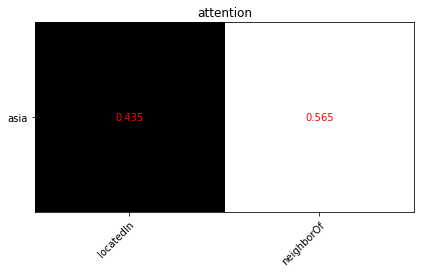

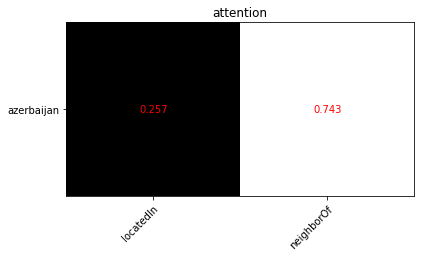

[['asia'], ['azerbaijan']]
locatedIn yemen


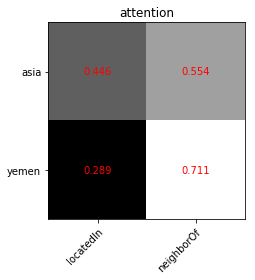

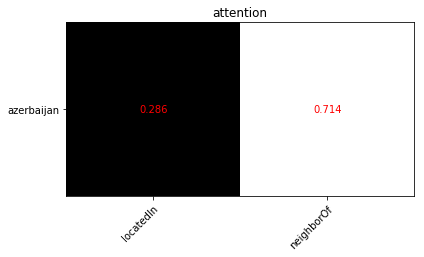

[['asia', 'yemen'], ['azerbaijan']]
neighborOf oman


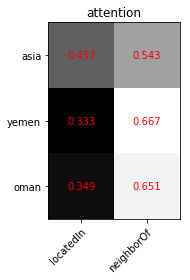

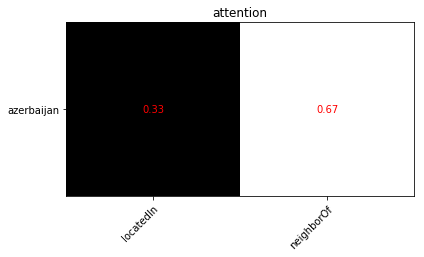

[['asia', 'yemen', 'oman'], ['azerbaijan']]
neighborOf armenia


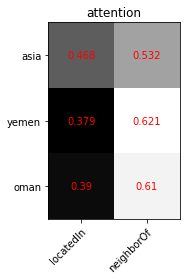

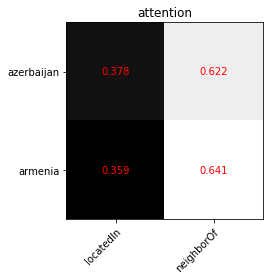

In [3]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

def find_ename(e):
    for e_name in state.graph.en_vocab:
        if state.graph.en_vocab[e_name] == e:
            return e_name
        
def find_rname(r):
    for r_name in state.graph.rel_vocab:
        if state.graph.rel_vocab[r_name] == r:
            return r_name
            

def print_attention():
    with torch.no_grad():
        projected_Rt = torch.t(state.word2node(torch.Tensor(state.Rt)))
        rs = []
        for r in state.rs:
            rs.append(find_rname(r))      
                        
        for i, subgraph in enumerate(state.subgraphs):
            gti = []
            es = []
            for e in subgraph:
                gti.append(state.node_embedding[e])
                es.append(find_ename(e))
            gti = torch.Tensor(gti)
            L = torch.mm(gti,projected_Rt)
            A_Rt = F.softmax(L, dim=1)
            
            fig, ax = plt.subplots()
            im = ax.imshow(A_Rt,cmap='gray')
            ax.set_xticks(np.arange(len(rs)))
            ax.set_yticks(np.arange(len(es)))
            ax.set_xticklabels(rs)
            ax.set_yticklabels(es)
            
            # Rotate the tick labels and set their alignment.
            plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

            # Loop over data dimensions and create text annotations.
            for i in range(len(es)):
                for j in range(len(rs)):
                    text = ax.text(j, i, round(A_Rt[i, j].item(),3), ha="center", va="center", color="r")

            ax.set_title("attention")
            fig.tight_layout()
            plt.show()

state = State((train[0][1],train[0][2]), kg, WORD_EMB_DIM, word2node, attention, rel_embedding, T)
answer = kg.en_vocab[train[i][0]]
e0 = state.subgraphs[0][0]
agent.policy.init_path(e0)

# go for T step
for step in range(T):
    print_attention()
    text_subgraphs = []
    for subgraph in state.subgraphs:
        temp = []
        for e in subgraph:
            temp.append(find_ename(e))
        text_subgraphs.append(temp)
    print(text_subgraphs)
    embedded_state = state.get_embedded_state()
    possible_actions = state.generate_all_possible_actions()
    action = agent.get_action(embedded_state, possible_actions)
    r, e = action
    print(find_rname(r), find_ename(e))
    if step < T-1:
        agent.hard_reward(0)
    else:
        if answer == e:
            agent.hard_reward(1)
        else:
            answer_embedding = state.node_embedding[answer]
            e_embedding = state.node_embedding[e]
            agent.soft_reward(answer_embedding, e_embedding, SOFT_REWARD_SCALE)
    state.update(action) 
print_attention()    

Parameter containing:
tensor([[-0.0231,  0.0345, -0.0024,  ...,  0.0043,  0.0059, -0.0285],
        [ 0.0075, -0.0653,  0.0121,  ..., -0.0427, -0.0371, -0.0151],
        [ 0.0130, -0.0058, -0.0467,  ..., -0.0144, -0.0086, -0.0456],
        ...,
        [-0.0249,  0.0097,  0.0436,  ..., -0.0175, -0.0471, -0.0223],
        [-0.0365,  0.0299, -0.0302,  ...,  0.0414,  0.0230, -0.0454],
        [-0.0366,  0.0197, -0.0279,  ..., -0.0101, -0.0358, -0.0059]],
       requires_grad=True)
